# Imports and Setup

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import necessary packages for data processing, HuBERT feature extration, and modeling.

Import `torch` as HuBERT model is only available in PyTorch, Hugging Face does not provide a native TensorFlow version with pre-trained weights.  `librosa` for loading and processing raw audio files.

In [ ]:

import os
import sys
import json
import warnings
from datetime import datetime
import numpy as np
import pandas as pd
# from tqdm import tqdm
from tqdm.notebook import tqdm

import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization, Add, LeakyReLU, Lambda, Attention,
    Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    LSTM, Bidirectional
)

# Install HuggingFace Transformers and PyTorch
!pip install -q transformers torch
from transformers import HubertModel, Wav2Vec2FeatureExtractor
import torch
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.2 MB/s eta 0:00:00


In [ ]:
# Check for GPU
print("TensorFlow GPU Available:", tf.config.list_physical_devices('GPU'))
print("PyTorch Device:", "cuda" if torch.cuda.is_available() else "cpu")

TensorFlow GPU Available: []
PyTorch Device: cpu


In [ ]:
# Path setup - adapt to your Google Colab
DRIVE_ROOT = '/content/drive/MyDrive/emotion_recognition_project'
os.makedirs(DRIVE_ROOT, exist_ok=True)


# Data Loading and preprocessing

Load the file: processed_metadata.csv and keep the successfully processed.

In [ ]:
# Load metadata - this has already been preprocessed with 16kHz, 4s segments
metadata_path = os.path.join(DRIVE_ROOT, "processed_metadata.csv")
all_df = pd.read_csv(metadata_path)


In [ ]:
# Keep only successfully processed files
all_df = all_df[all_df['processed_success'] == True].reset_index(drop=True)
print(f"Working with {len(all_df)} processed audio files")
print(f"Labels: {all_df['label'].unique()}")


Working with 12162 processed audio files
Labels: ['happy' 'fear' 'disgust' 'angry' 'surprise' 'neutral' 'sad']


# **Experiment 1** - mean+std pooling HuBERT feature extraction

### Main steps:
- **Model setup**  
  Load HuBERT and select middle layer (`LAYER_SELECT = -4`) for better generalization.

- **Audio preprocessing**  
  Load audio files at 16 kHz.

- **Feature extraction**  
  - Get hidden states from HuBERT.  
  - Select the specified layer as mentioned above.  
  - Compute mean and std across time.  
  → Final feature vector: **[1536]** (768 mean + 768 std).

- **Dataset split**  
  80% train, 20% validation.

- **One-hot encoding**  
  Encode emotion labels using `OneHotEncoder`.

- **Caching**  
  Save extracted features and labels as `.npy` files to avoid reprocessing.

---

### Output summary:
- Train set → `X_train.npy`, `y_train.npy`  
- Validation set → `X_val.npy`, `y_val.npy`


In [ ]:
# Setups
SR = 16000  # This matches your preprocessing
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LAYER_SELECT = -4    # Middle layer for better generalization

save_dir = os.path.join(DRIVE_ROOT, "hubert_meanstd_no_aug")
os.makedirs(save_dir, exist_ok=True)
print(f"Model 1 (Mean+Std) saving to: {save_dir}")

Model 1 (Mean+Std) saving to: /content/drive/MyDrive/emotion_recognition_project/hubert_meanstd_no_aug


In [ ]:
# Loading Hubert
print("Loading HuBERT model...")
model = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(DEVICE)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
model.eval()

Loading HuBERT model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

HubertModel(
  (feature_extractor): HubertFeatureEncoder(
    (conv_layers): ModuleList(
      (0): HubertGroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): HubertFeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): HubertEncoder(
    (pos_conv_embed): HubertPositionalConvEmbedding(
      (conv): Para

In [ ]:
# Functions
def load_audio_file(path):
    """Simply load the preprocessed audio file"""
    audio, _ = librosa.load(path, sr=SR)
    return audio

def extract_meanstd_feature(audio):
    """Extract mean and std features from HuBERT"""
    inputs = feature_extractor(audio, sampling_rate=SR, return_tensors="pt")
    with torch.no_grad():
        hidden_states = model(inputs.input_values.to(DEVICE), output_hidden_states=True).hidden_states
        selected = hidden_states[LAYER_SELECT].squeeze(0).cpu().numpy()
    mean_pool = np.mean(selected, axis=0)
    std_pool = np.std(selected, axis=0)
    return np.concatenate([mean_pool, std_pool])   # Shape: [1536]


In [ ]:
# Split Train / Val
train_df, val_df = train_test_split(all_df, test_size=0.2, random_state=42, stratify=all_df['label'])
print(f"Train: {len(train_df)}, Val: {len(val_df)}")


Train: 9729, Val: 2433


In [ ]:
# One hot encoding
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(all_df[['label']])
label_names = ohe.categories_[0].tolist()

with open(os.path.join(save_dir, "label_names.json"), "w") as f:
    json.dump(label_names, f)
print(f"Labels: {label_names}")

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:

# Process Train Set (with feature caching for saving)
train_feature_path = os.path.join(save_dir, "X_train.npy")
train_label_path = os.path.join(save_dir, "y_train.npy")

if os.path.exists(train_feature_path) and os.path.exists(train_label_path):
    print("Loading existing train features...")
    X_train = np.load(train_feature_path)
    y_train = np.load(train_label_path)
else:
    print("Extracting train features...")
    train_features, train_labels = [], []
    for _, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Extracting Train Features"):
        try:
            audio = load_audio_file(row['processed_path'])
            train_features.append(extract_meanstd_feature(audio))
            train_labels.append(row['label'])
        except Exception as e:
            print(f"Error processing {row['processed_path']}: {e}")
            continue

    X_train = np.stack(train_features)
    y_train = ohe.transform(np.array(train_labels).reshape(-1,1))

    # Save features
    np.save(train_feature_path, X_train)
    np.save(train_label_path, y_train)

Loading existing train features...


In [ ]:
# Process Val Set (with feature caching)
val_feature_path = os.path.join(save_dir, "X_val.npy")
val_label_path = os.path.join(save_dir, "y_val.npy")

if os.path.exists(val_feature_path) and os.path.exists(val_label_path):
    print("Loading existing validation features...")
    X_val = np.load(val_feature_path)
    y_val = np.load(val_label_path)
else:
    print("Extracting validation features...")
    val_features, val_labels = [], []
    for _, row in tqdm(val_df.iterrows(), total=len(val_df), desc="Extracting Val Features"):
        try:
            audio = load_audio_file(row['processed_path'])
            val_features.append(extract_meanstd_feature(audio))
            val_labels.append(row['label'])
        except Exception as e:
            print(f"Error processing {row['processed_path']}: {e}")
            continue

    X_val = np.stack(val_features)
    y_val = ohe.transform(np.array(val_labels).reshape(-1,1))

    # Save features
    np.save(val_feature_path, X_val)
    np.save(val_label_path, y_val)

print(f"Features saved: Train {X_train.shape}, Val {X_val.shape}")


Loading existing validation features...
Features saved: Train (9729, 1536), Val (2433, 1536)


In case the system ram crashed or too high already now, run the following code to for releasing it. Also at any stage in doing HuBERT features, this method can always be used repeatedly to garantee some more enough system ram.

In [ ]:
import gc
tf.keras.backend.clear_session()
gc.collect()

### Model Architecture
**Input Layer:**
Accepts input of shape (input_dim,) from preprocessed features.

**Dense Block:**

- Dense(512) layer with L2 regularization (λ = 1e-4) to learn global feature patterns.

- BatchNormalization to stabilize training.

- LeakyReLU activation.

- Dropout with rate 0.4 for regularization.

**Residual Block:**

- Main path: Dense(384) → LeakyReLU → Dense(512) → BatchNormalization.

- Skip connection: Dense(512) added to the main path.

- Add() merges both paths for residual learning.

**Attention Mechanism:**

- Input expanded to shape (batch, 1, 512) using Lambda.

- Attention layer computes raw attention scores.

- Output squeezed back to (batch, 512) using Lambda.

**MLP Head:**

- Dense(128, relu) → Dropout(0.4).

- Dense(64, relu) → Dropout(0.3).

**Output Layer:**

Dense(num_classes, softmax) for multi-class prediction.


### Model complilation
- Optimizer: AdamW (lr = 1e-4)

- Loss: CategoricalCrossentropy with label_smoothing = 0.08

- Metrics: accuracy


In [ ]:

# Define the model
num_classes = y_train.shape[1]  # Make sure this is correct
input_shape = (X_train.shape[1],)

from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Dropout, Add, Lambda, Attention
from tensorflow.keras.models import Model

inputs = Input(shape=input_shape)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.4)(x)

residual = Dense(512)(x)
x = Dense(384)(x)
x = LeakyReLU()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Add()([x, residual])

x_expanded = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)  # shape: (batch, 1, 512)
attn_out = Attention()([x_expanded, x_expanded])              # shape: (batch, 1, 512)
x = Lambda(lambda t: tf.squeeze(t, axis=1))(attn_out)         # shape: (batch, 512)

x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.08),
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1536)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    786,944 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 512)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 384)       │    196,992 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 384)       │          0 │ dense_2[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    197,120 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    262,656 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 512)       │          0 │ batch_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 512)    │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 1, 512)    │          0 │ lambda[0][0],     │
│ (Attention)         │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 512)       │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     65,664 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 7)         │        455 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,522,183 (5.81 MB)

 Trainable params: 1,520,135 (5.80 MB)

 Non-trainable params: 2,048 (8.00 KB)

### Model Training
**Set Callbacks:**

- `ReduceLROnPlateau`: Reduce learning rate when val_loss plateaus.

- `EarlyStopping`: Stop early if val_loss stops improving, and restore the best weights.

**Training settings**
- Epochs: 80

- Batch size: 128

- Callbacks: as above

**Save Model and History**
- Save trained model to disk.

- Save training history (loss, accuracy, etc.) as a JSON file.

In [ ]:
model_path = os.path.join(save_dir, "final_model_meanstd.keras")
training_history_path = os.path.join(save_dir, "training_history.json")

print("Training new model from scratch...")

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

# Save model and training history
model.save(model_path)

with open(training_history_path, 'w') as f:
    json.dump(history.history, f)

print("Training complete & model + history saved here!")

Training new model from scratch...
Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.1916 - loss: 2.7190 - val_accuracy: 0.3757 - val_loss: 1.9563 - learning_rate: 1.0000e-04
Epoch 2/80
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3588 - loss: 1.8764 - val_accuracy: 0.4661 - val_loss: 1.8680 - learning_rate: 1.0000e-04
Epoch 3/80
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4311 - loss: 1.6897 - val_accuracy: 0.5380 - val_loss: 1.7309 - learning_rate: 1.0000e-04
Epoch 4/80
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4900 - loss: 1.5521 - val_accuracy: 0.5462 - val_loss: 1.6216 - learning_rate: 1.0000e-04
Epoch 5/80
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5315 - loss: 1.4687 - val_accuracy: 0.6527 - val_loss: 1.4475 - learning_rate: 1.0000e-04
Epoch 6/80
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5790 - loss: 1.3874 - val_accuracy: 0.6568 - val_loss: 1.3451 - learning_rate: 1.0000e-04
Epoch 7/80
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5971 - loss: 1.3

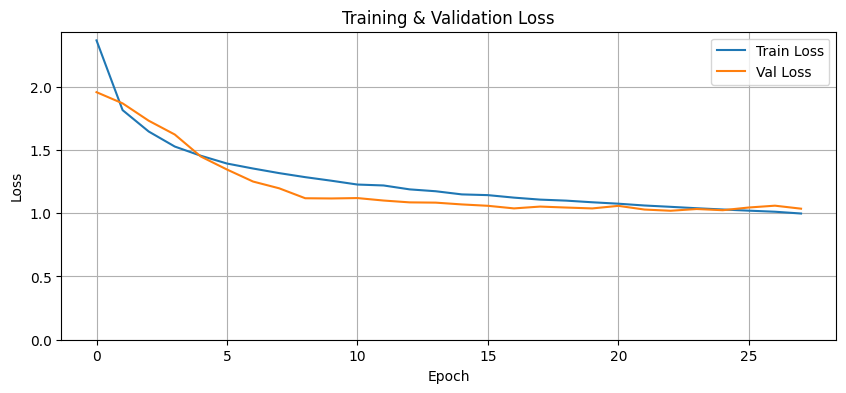

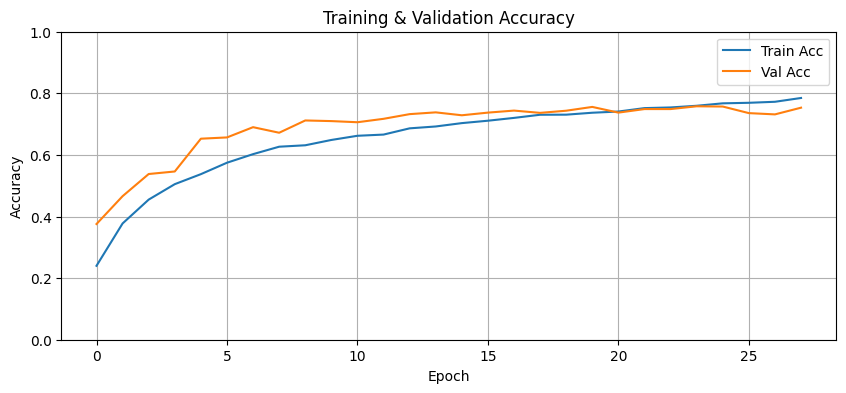

In [ ]:
# Plot training history
if history:
    # Loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.ylim(0)
    plt.grid(True)
    plt.show()

    # Accuracy
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

In [ ]:
# Predict on validation set
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

46/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Classification Report:
              precision    recall  f1-score   support

       angry       0.90      0.79      0.84       385
     disgust       0.78      0.69      0.73       384
        fear       0.79      0.60      0.68       385
       happy       0.63      0.81      0.71       385
     neutral       0.81      0.88      0.84       379
         sad       0.62      0.72      0.67       385
    surprise       0.93      0.80      0.86       130

    accuracy                           0.75      2433
   macro avg       0.78      0.75      0.76      2433
weighted avg       0.76      0.75      0.75      2433



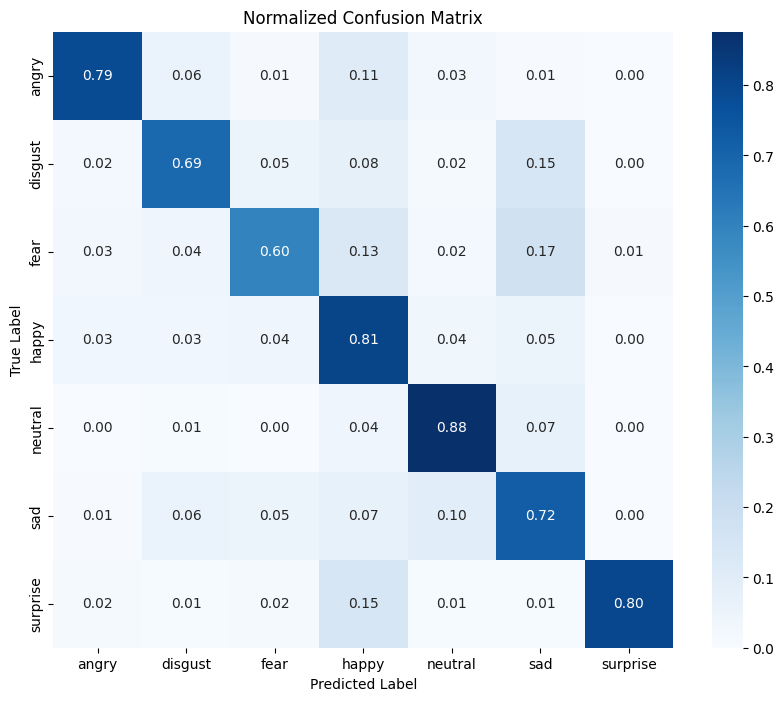

In [ ]:
# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_names))

# confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')  # Row-wise normalization

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Result Discussion

**Key metrics:**

- Val accuracy: 74.89%
- Macro avg f1-score: 76%

**Observations**

Training & Validation curves
- Both training and validation loss decreased steadily over 23 epochs.
- Validation accuracy stabilized and slightly surpassed training accuracy, indicating good generalization.
- No sign of overfitting up to the stopping point.

Classification Report Highlights:

- Best performance on: angry (F1: 0.84), neutral (F1: 0.84), and surprise (F1: 0.86)

- Weaker performance on: fear (F1: 0.68) and sad (F1: 0.67), suggesting confusion in these emotional classes.

- Macro average and weighted average F1 both around 0.75, showing fairly balanced performance across classes.

Confusion Matrix Insights:

- happy is often confused with neutral and angry.

- fear and disgust show cross-confusion with multiple classes.

- surprise and neutral have the clearest and most confident predictions.

**Takeaways:**

The model demonstrates strong overall emotion classification performance, especially on high-intensity emotions like surprise and angry.

Moderate difficulty remains in distinguishing subtle negative emotions like fear and sad, suggesting these require richer features or additional data.

# **Experiment 2** - Full HuBERT feature extraction

### Main steps:
- **Model setup**  
  Load HuBERT (facebook/hubert-base-ls960) and freeze all layers by default. Optionally unfreeze the last N layers (LAYER_UNFREEZE = 4) for fine-tuning. Use GPU if available.

- **Audio preprocessing**  
  Load audio files at 16 kHz.

- **Feature extraction**  
  - Pass audio through the HuBERT model to get hidden states.
  - Extract the full sequence of embeddings (up to MAX_FRAMES = 200), padding or truncating as needed.
  - Final shape per sample: [200, 768] (time steps × features).

- **Dataset split**  
  80% train, 20% validation.

- **One-hot encoding**  
  Encode emotion labels using `OneHotEncoder`.

- **Caching**  
  Save extracted features and labels as `.npy` files to avoid reprocessing.
---

### Output summary:
- Train set → `X_train.npy`, `y_train.npy`  
- Validation set → `X_val.npy`, `y_val.npy`


In [ ]:
# Clear memory to avoid any potential issues
import gc
gc.collect()
tf.keras.backend.clear_session()

In [ ]:
# Configuration
LAYER_UNFREEZE = 4
SR = 16000  # This matches your preprocessing
MAX_FRAMES = 200
SAVE_DIR = os.path.join(DRIVE_ROOT, "hubert_full_no_aug")
os.makedirs(SAVE_DIR, exist_ok=True)
print(f"Model 2 (Full Sequence) saving to: {SAVE_DIR}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Model 2 (Full Sequence) saving to: /content/drive/MyDrive/emotion_recognition_project/hubert_full_no_aug


In [ ]:
# Load HuBERT model and feature extractor
print("Loading HuBERT model...")
hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(DEVICE)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")

for param in hubert_model.parameters():
    param.requires_grad = False
if LAYER_UNFREEZE > 0:
    for param in hubert_model.encoder.layers[-LAYER_UNFREEZE:].parameters():
        param.requires_grad = True
hubert_model.eval()

Loading HuBERT model...


HubertModel(
  (feature_extractor): HubertFeatureEncoder(
    (conv_layers): ModuleList(
      (0): HubertGroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): HubertFeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): HubertEncoder(
    (pos_conv_embed): HubertPositionalConvEmbedding(
      (conv): Para

In [ ]:
# HuBERT Feature Extraction for full sequence
def extract_embedding(audio):
    """Extract full sequence features using HuBERT"""
    inputs = feature_extractor(audio, sampling_rate=SR, return_tensors="pt")
    with torch.no_grad():
        outputs = hubert_model(inputs.input_values.to(DEVICE)).last_hidden_state
        sequence = outputs.squeeze(0).cpu().numpy()

    # Ensure fixed length output (pad or truncate)
    if sequence.shape[0] >= MAX_FRAMES:
        return sequence[:MAX_FRAMES]
    else:
        return np.vstack((sequence, np.zeros((MAX_FRAMES - sequence.shape[0], sequence.shape[1]))))


In [ ]:
# One-Hot Encoding
# We'll use the same one-hot encoder as before for consistency accross experiments
with open(os.path.join(SAVE_DIR, "label_names.json"), "w") as f:
    json.dump(label_names, f)


In [ ]:
# Extract Train Features (with feature caching)
train_feature_path = os.path.join(SAVE_DIR, "X_train.npy")
train_label_path = os.path.join(SAVE_DIR, "y_train.npy")


In [ ]:
if os.path.exists(train_feature_path) and os.path.exists(train_label_path):
    print("Loading existing train features...")
    X_train = np.load(train_feature_path)
    y_train = np.load(train_label_path)
else:
    print("Extracting train features...")
    train_features, train_labels = [], []
    for _, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Extracting Train Features"):
        try:
            audio = load_audio_file(row['processed_path'])
            train_features.append(extract_embedding(audio))
            train_labels.append(row['label'])
        except Exception as e:
            print(f"Error processing {row['processed_path']}: {e}")
            continue

    X_train = np.stack(train_features)
    y_train = ohe.transform(np.array(train_labels).reshape(-1, 1))

    # Save features
    np.save(train_feature_path, X_train)
    np.save(train_label_path, y_train)

print(f"Saved Train Features: {X_train.shape}")

Loading existing train features...
Saved Train Features: (9729, 200, 768)


In [ ]:
# Extract Validation Features (with feature caching)
val_feature_path = os.path.join(SAVE_DIR, "X_val.npy")
val_label_path = os.path.join(SAVE_DIR, "y_val.npy")

if os.path.exists(val_feature_path) and os.path.exists(val_label_path):
    print("Loading existing validation features...")
    X_val = np.load(val_feature_path)
    y_val = np.load(val_label_path)
else:
    print("Extracting validation features...")
    val_features, val_labels = [], []
    for _, row in tqdm(val_df.iterrows(), total=len(val_df), desc="Extracting Validation Features"):
        try:
            audio = load_audio_file(row['processed_path'])
            val_features.append(extract_embedding(audio))
            val_labels.append(row['label'])
        except Exception as e:
            print(f"Error processing {row['processed_path']}: {e}")
            continue

    X_val = np.stack(val_features)
    y_val = ohe.transform(np.array(val_labels).reshape(-1, 1))

    # Save features
    np.save(val_feature_path, X_val)
    np.save(val_label_path, y_val)

print(f"Saved Validation Features: {X_val.shape}")
print(f"\nFeature extraction completed. All data saved to {SAVE_DIR}")


Loading existing validation features...
Saved Validation Features: (2433, 200, 768)

Feature extraction completed. All data saved to /content/drive/MyDrive/emotion_recognition_project/hubert_full_no_aug


### Model Architecture
**Input Layer:**
Accepts input of shape (input_dim,) from preprocessed features.

**CNN Block:**

- Conv1D(64, kernel_size=3, padding='same', relu) with L2 regularization (λ = 1e-4) to extract local temporal patterns.

- BatchNormalization.

- MaxPooling1D(pool_size=2) for downsampling.

- Dropout(0.5) for regularization.

**BiLSTM Block:**

- Bidirectional LSTM(128) with return_sequences=True to capture contextual dependencies in both time directions.

- Includes dropout=0.5, recurrent_dropout=0.3, and L2 regularization (λ = 1e-4).

- GlobalAveragePooling1D to reduce the time dimension and produce a fixed-length vector.

**MLP Head:**

- Dense(128, relu) with L2 regularization (λ = 1e-4).

- Dropout(0.5) for further regularization.

**Output Layer:**

Dense(num_classes, softmax) for multi-class prediction.


### Model complilation
- Optimizer: AdamW (lr = 1e-4)

- Loss: CategoricalCrossentropy with label_smoothing = 0.05

- Metrics: accuracy


In [ ]:
# Build CNN+BiLSTM Model
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

inputs = Input(shape=input_shape)
x = Conv1D(64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.5)(x)

x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.3, kernel_regularizer=tf.keras.regularizers.l2(1e-4)))(x)
x = GlobalAveragePooling1D()(x)

x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model2 = Model(inputs, outputs)
model2.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)]
)

model2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 200, 64)        │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)       │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 379,207 (1.45 MB)

 Trainable params: 379,079 (1.45 MB)

 Non-trainable params: 128 (512.00 B)

### Model Training
**Set Callbacks:**

- `ReduceLROnPlateau`: Reduce learning rate when val_loss plateaus.

- `EarlyStopping`: Stop early if val_loss stops improving, and restore the best weights.

**Training settings**
- Epochs: 60

- Batch size: 128

- Callbacks: as above

**Save Model and History**
- Save trained model to disk.

- Save training history (loss, accuracy, etc.) as a JSON file.

In [ ]:
# Train Model (with model loading if exists)
model2_path = os.path.join(SAVE_DIR, "cnn_bilstm_model.keras")
if os.path.exists(model2_path):
    print(f"Loading existing model from {model2_path}")
    model2 = tf.keras.models.load_model(model2_path)
    training_history_path = os.path.join(SAVE_DIR, "training_history.json")
    if os.path.exists(training_history_path):
        with open(training_history_path, 'r') as f:
            history_dict = json.load(f)
        history2 = type('obj', (object,), {'history': history_dict})
    else:
        # If we have a model but no history, we'll skip plotting
        history2 = None
else:
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    ]
    history2 = model2.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=60,
        batch_size=128,
        callbacks=callbacks,
        verbose=1
    )

    # Save model
    model2.save(model2_path)

    # Save training history for later loading
    with open(os.path.join(SAVE_DIR, "training_history.json"), 'w') as f:
        json.dump(history2.history, f)

    print("Training complete. Model saved!")

Epoch 1/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 36s 390ms/step - accuracy: 0.1856 - loss: 1.9714 - top_k_categorical_accuracy: 0.5148 - val_accuracy: 0.2577 - val_loss: 1.8765 - val_top_k_categorical_accuracy: 0.6835 - learning_rate: 1.0000e-04
Epoch 2/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 29s 371ms/step - accuracy: 0.2914 - loss: 1.8539 - top_k_categorical_accuracy: 0.6634 - val_accuracy: 0.4135 - val_loss: 1.7129 - val_top_k_categorical_accuracy: 0.7744 - learning_rate: 1.0000e-04
Epoch 3/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 27s 356ms/step - accuracy: 0.3847 - loss: 1.7045 - top_k_categorical_accuracy: 0.7680 - val_accuracy: 0.4455 - val_loss: 1.5518 - val_top_k_categorical_accuracy: 0.8381 - learning_rate: 1.0000e-04
Epoch 4/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 29s 375ms/step - accuracy: 0.4462 - loss: 1.5729 - top_k_categorical_accuracy: 0.8166 - val_accuracy: 0.4842 - val_loss: 1.4477 - val_top_k_categorical_accuracy: 0.8471 - learning_rate: 1.0000e-04
Epoch 5/60
77/77 ━━━━━━━━━━━━━━━━━━━━ 27s 354ms/step - accur

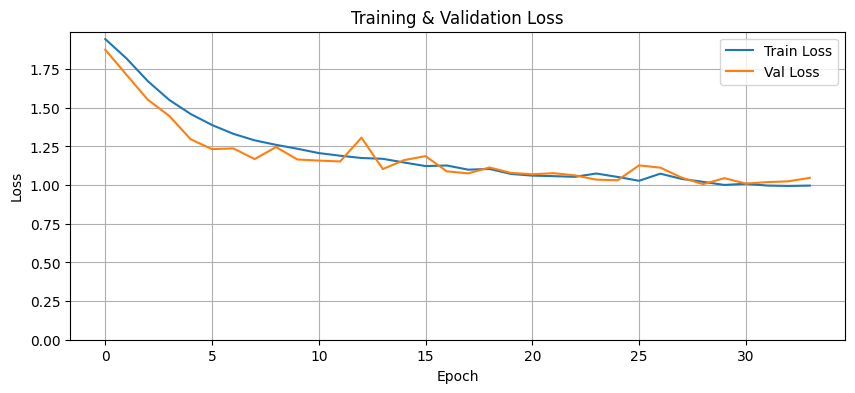

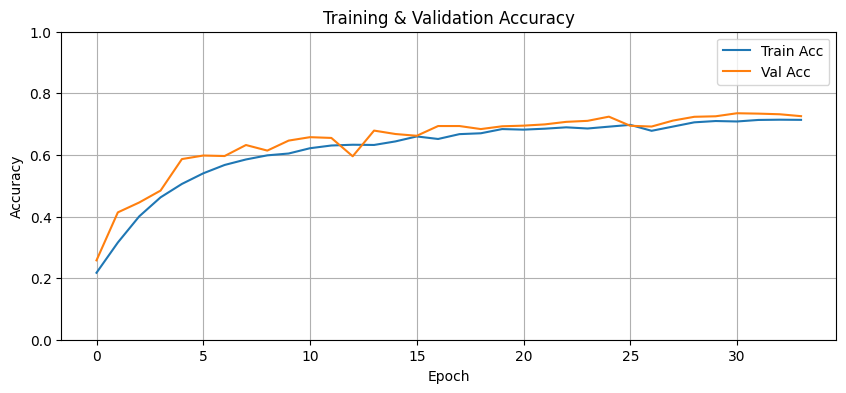

In [ ]:
# Plot Training History if we have it
if history2:
    # Loss
    plt.figure(figsize=(10, 4))
    plt.plot(history2.history['loss'], label='Train Loss')
    plt.plot(history2.history['val_loss'], label='Val Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.ylim(0)
    plt.grid(True)
    plt.show()

    # Accuracy
    plt.figure(figsize=(10, 4))
    plt.plot(history2.history['accuracy'], label='Train Acc')
    plt.plot(history2.history['val_accuracy'], label='Val Acc')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

In [ ]:
# Predict on validation set
y_pred_probs2 = model2.predict(X_val)
y_pred2 = np.argmax(y_pred_probs2, axis=1)
y_true2 = np.argmax(y_val, axis=1)

77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step


Classification Report:
              precision    recall  f1-score   support

       angry       0.81      0.83      0.82       385
     disgust       0.67      0.70      0.69       384
        fear       0.66      0.69      0.67       385
       happy       0.75      0.60      0.67       385
     neutral       0.79      0.86      0.82       379
         sad       0.63      0.62      0.63       385
    surprise       0.81      0.87      0.84       130

    accuracy                           0.72      2433
   macro avg       0.73      0.74      0.73      2433
weighted avg       0.72      0.72      0.72      2433



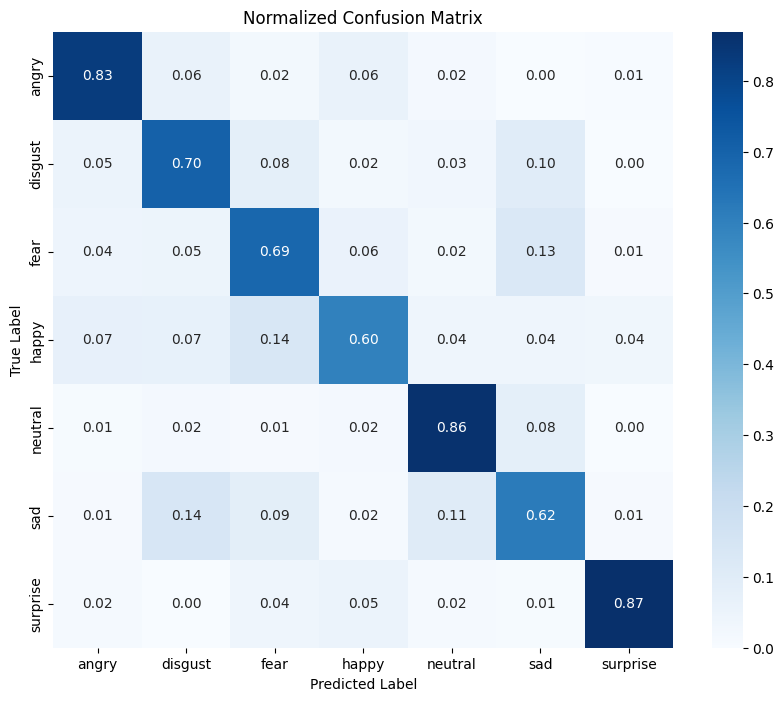

In [ ]:

# Classification Report=
print("Classification Report:")
print(classification_report(y_true2, y_pred2, target_names=label_names))

# Confusion Matrix (Normalized)
cm2 = confusion_matrix(y_true2, y_pred2, normalize='true')  # Row-wise normalization

plt.figure(figsize=(10, 8))
sns.heatmap(cm2, annot=True, fmt=".2f", cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Final comparison of the approaches
print("\nModel Comparison")
print(f"Model 1 (Mean+Std Pooling): {np.mean(y_pred == y_true)*100:.2f}% accuracy")
print(f"Model 2 (Full Sequence CNN+BiLSTM): {np.mean(y_pred2 == y_true2)*100:.2f}% accuracy")


Model Comparison
Model 1 (Mean+Std Pooling): 74.89% accuracy
Model 2 (Full Sequence CNN+BiLSTM): 72.38% accuracy


### Result Discussion

**Key metrics:**

- Val accuracy: 72.59%
- Macro avg f1-score: 73%

**Observations**

Training & Validation curves
- Both training and validation loss decreased steadily over 29 epochs.
- Validation accuracy stabilized and slightly surpassed training accuracy, indicating good generalization.
- No sign of overfitting up to the stopping point.

Classification Report Highlights:

- Best performance on: angry (F1: 82%), neutral (F1: 84%)

- Weaker performance on: fear (F1: 67%) and sad (F1: 63%), suggesting confusion in these emotional classes.

- Macro average around 75%, showing fairly balanced performance across classes.

Confusion Matrix Insights:

- happy is often confused with neutral and angry.

- fear and disgust show cross-confusion.

- surprise and neutral have the clearest and most confident predictions.

**Takeaways:**

The model demonstrates strong overall emotion classification performance, especially on high-intensity emotions like surprise and angry.

Discrimination between subtle negative emotions (fear, sad) remains a challenge, likely due to overlap in their acoustic features.

Increasing training data for underperforming classes may help boost performance.
